fixed borate code, calculation of revelle factor code
no maps; see Revelle_calc for maps

In [18]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Notebook overview

    Aim 1: compile references for buffer code (section 1)
    Aim 2: Trying to build code calculate & plot all 6 buffer factors calculated in Egleston 2010, as well as the classical Revelle factor. I can't reproduce the values they get in their paper and am unsure why - see sections 4-8. 




## 1. References

{Egleston 2010}
Since Revelle and Suess first introduced the concept of an
oceanic carbon buffer, several methods have been used for
calculating or estimating R [Broecker et al., 1979;
Sarmiento and Gruber, 2006]. Broecker et al. stated that
the Revelle factor is a function of the ratio of DIC to
alkalinity. By examining the explicit expression of R, we
can demonstrate that this is mathematically true under the
assumption that the minor species borate, proton, and
hydroxide can be neglected compared to bicarbonate. 

### Reference: buffer factors as derived by Egleston 2010:
<img src="./Egleston_Table1.png">


### DIC and TA proportional makeup reference, Gruber-Sarmiento Ch8:

<img src="./Sarmiento_percentages.png">

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [20]:
import sys
#sys.path.append('/data/tjarniko/MEOPAR/mocsy')
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/')
import mocsy
import VIZ_plots as VP

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from oct2py import octave
import seawater as sw
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
from matplotlib import reload
plt.style.use('seaborn-bright')
import netCDF4 as nc
import numpy as np
import cmocean as cm
# import CCCma_stations as STN
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

%matplotlib inline

## Output of one day - does it look reasonable?

In [21]:
## Retreive one dataset 
date = 'Nov 13, 2014'
daypath = '/results/SalishSea/spinup.201812/13nov14/'
ptrc = 'SalishSea_1d_*_carp_T.nc'
grid = 'SalishSea_1d_*_grid_T.nc'
ptt = daypath  + ptrc
ptg = daypath + grid
pttG = glob.glob(ptt)
ptgG = glob.glob(ptg)

carp_nc = nc.Dataset(pttG[0])
grid_nc = nc.Dataset(ptgG[0])


In [22]:
def surface_maps(carp,grid, ddmmmyy, rdir,humandate, dss_sig):
    
    tsal = grid.variables['vosaline'][0,0,:,:]
    ttemp = grid.variables['votemper'][0,0,:,:]
    tdic = carp.variables['dissolved_inorganic_carbon'][0,0,:,:]
    tta = carp.variables['total_alkalinity'][0,0,:,:]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)

    response_tup = mocsy.mvars(temp=ttera, sal=tsra, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tzero, depth=tzero, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(898,398)
    OmA = OmegaA.reshape(898,398)
    
    surf_dat = [tsal, tdic, tta, ttemp, pHr, OmA]
    
    vmins = [25,1800,1800,5,7.5,0]
    vmaxs = [32,2200,2200,15,8.5,2]
    msk = [0,0,0,0,1e20,1e20]
    cl = ['salinity psu', 'DIC mmol/m3', 'TA mmol/m3', 'temp deg C', 'pH', 'Omega A']
    t_cmap = [cm.cm.haline, cm.cm.matter, cm.cm.matter, cm.cm.thermal, cm.cm.speed, cm.cm.curl]

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = \
    plt.subplots(figsize=(20, 27) , nrows=2, ncols=3)

    viz_tools.set_aspect(ax1)
    viz_tools.set_aspect(ax2)
    viz_tools.set_aspect(ax3)
    viz_tools.set_aspect(ax4)
    viz_tools.set_aspect(ax5)
    viz_tools.set_aspect(ax6)

    i = 0
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax1.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax1)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 1
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax2.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax2)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 2
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax3.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax3)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 3
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax4.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax4)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 4
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax5.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax5)
    cbar.set_label(cl[i], fontsize = 20 )

    i = 5
    tplt0 = surf_dat[i]
    tplt = np.ma.masked_values(tplt0,msk[i])
    tcmap = t_cmap[i]
    mesh = ax6.pcolormesh(tplt, cmap=tcmap, vmin=vmins[i], vmax=vmaxs[i])
    cbar = fig.colorbar(mesh, ax=ax6)
    cbar.set_label(cl[i], fontsize = 20 )

    st = 'Salish Sea Carbonate Chemistry Map, ' + humandate
    plt.suptitle(st,fontsize=20)

    plt.show()

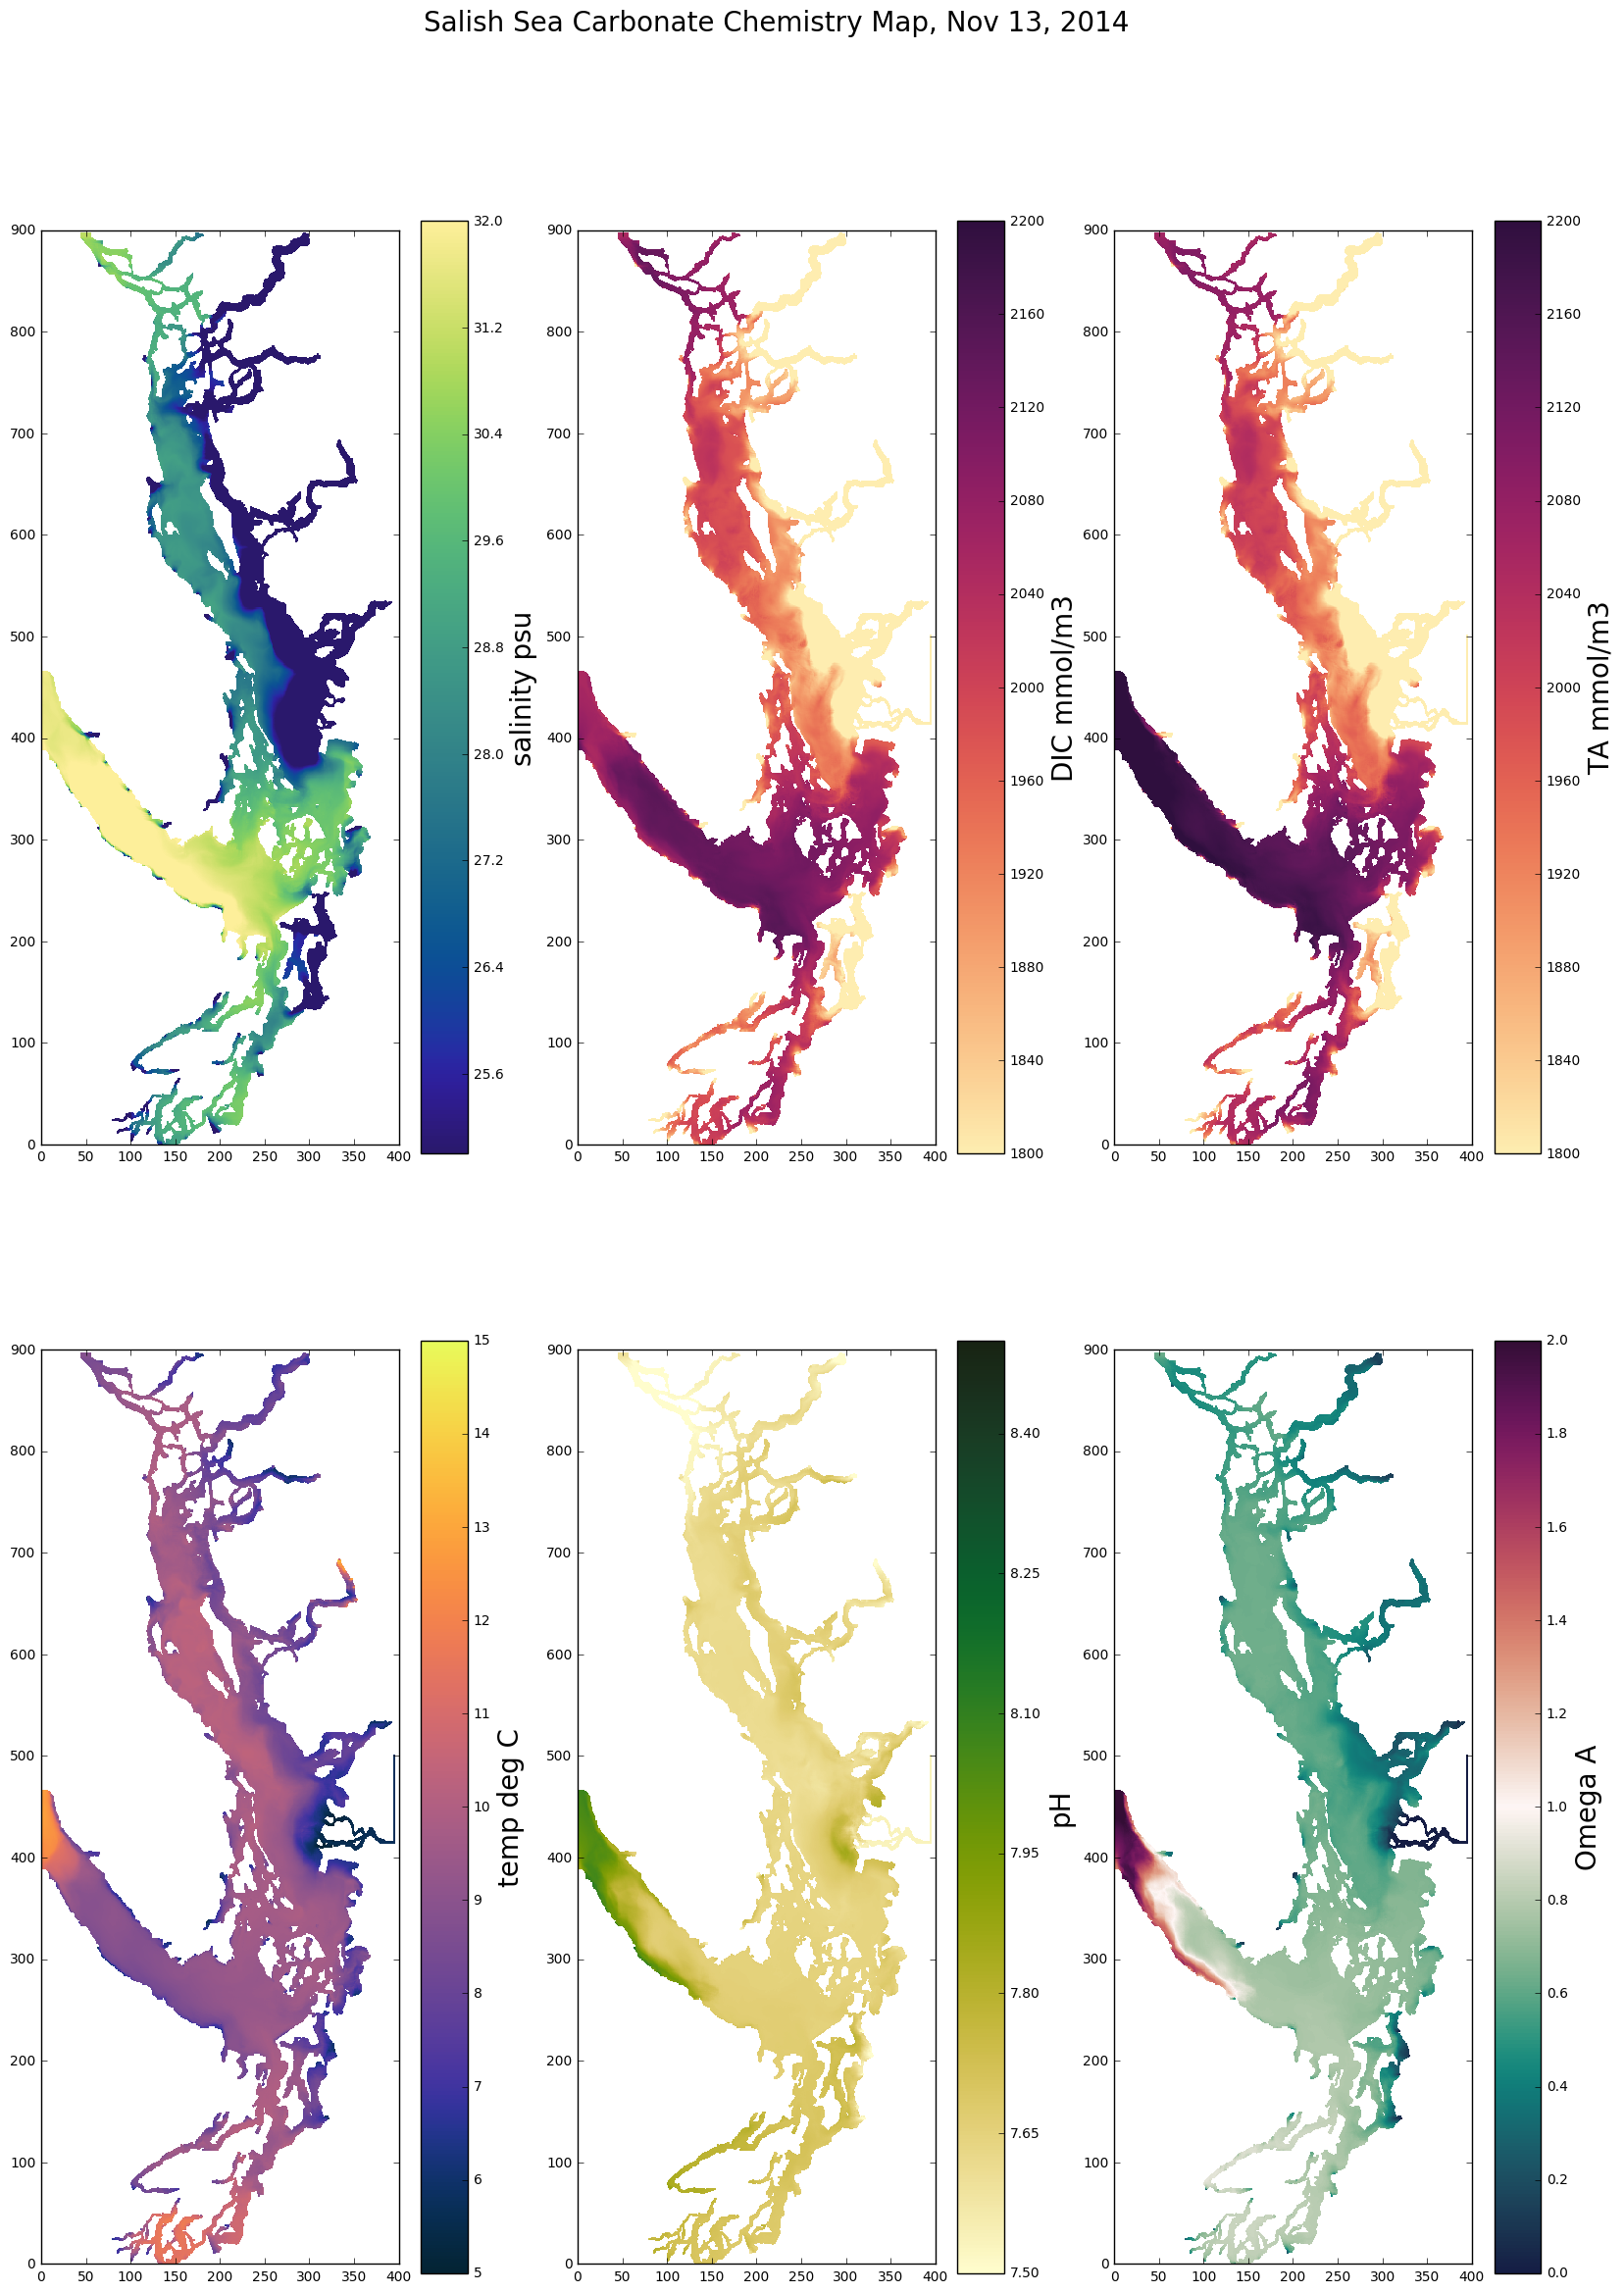

In [23]:
surface_maps(carp_nc,grid_nc, 'ddmmmyy' , 'rdir',date, 'dss_sig')

## 3) Point check of mocsy output - JdF waters y=400, x=50

Make sure that the values mocsy puts out aren't garbage/are plausible - yes. (We need mocsy output to calculate buffer factors.) At present there is no phosphate, silicate, and the patm = 0. At patm =1, these mocsy outputs are very similar - 3 uatm difference for pco2, speciation and pH values very similar indeed. 

        Mocsy output at patm = 0
        ~~~MOCSY OUTPUT~~
        pH: [ 7.84746113]
        pco2: [ 634.13513064]
        co2: [  2.97835710e-05]
        hco3: [ 0.0019442]
        co3: [  7.18200274e-05]
        OmegaA: [ 1.10299131]
        TA_carb from mocsy: [ 0.00208784]
        
        Mocsy output at patm = 1
        ~~~MOCSY OUTPUT~~
        pH: [ 7.84742219]
        pco2: [ 637.84197069]
        co2: [  2.97831492e-05]
        hco3: [ 0.0019442]
        co3: [  7.18186151e-05]
        OmegaA: [ 1.10277529]
        TA_carb from mocsy: [ 0.00208784]

In [24]:
y = 400
x = 50
tsal = grid_nc.variables['vosaline'][0,0,y,x]
ttemp = grid_nc.variables['votemper'][0,0,y,x]
tdic = carp_nc.variables['dissolved_inorganic_carbon'][0,0,y,x]
tta = carp_nc.variables['total_alkalinity'][0,0,y,x]

tsra = np.ravel(tsal)
ttera = np.ravel(ttemp)
ttara = np.ravel(tta) * 1e-3
tdra = np.ravel(tdic) * 1e-3
tzero = np.zeros_like(tsra)
tone = np.zeros_like(tsra)
tone[:] = 1

sal = tsra
dic = tdra
alk = ttara

print('sal: ' + str(tsra))
print('temp: ' + str(ttera))
print('dic: ' + str(tdra))
print('ta: ' + str(ttara))

response_tup = mocsy.mvars(temp=ttera, sal=tsra, alk=ttara, dic=tdra, 
                   sil=tzero, phos=tzero, patm=tzero, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

print('~~~MOCSY OUTPUT~~')
print('pH: ' + str(pH))
print('pco2: ' + str(pco2))
print('co2: ' + str(co2))
print('hco3: ' + str(hco3))
print('co3: ' + str(co3))
print('OmegaA: ' + str(OmegaA))


TA_carb = hco3 +2*co3
print('TA_carb from mocsy: '+str(TA_carb))




sal: [ 30.52309418]
temp: [ 8.78060055]
dic: [ 2.04580212]
ta: [ 2.12356067]
~~~MOCSY OUTPUT~~
pH: [ 7.83827026]
pco2: [ 629.46680135]
co2: [ 0.03026344]
hco3: [ 1.94481305]
co3: [ 0.0707259]
OmegaA: [ 1.06109578]
TA_carb from mocsy: [ 2.08626485]


## 4) calculating missing parameters for the buffer factor calc: B(OH)4, h+, oh-


### MATLAB subfxn for alkalinity components lines 1726-1756 - Ernie Lewis

###### Will rewrite for OH- and Balk in python...

function varargout=CalculateAlkParts(pHx, TCx) 
    global K0 K1 K2 KW KB KF KS KP1 KP2 KP3 KSi; 
    global TB TF TS TP TSi F; % 
    #SUB CalculateAlkParts, version 01.03, 10-10-97, written by Ernie Lewis. % '
    #Inputs: pH, TC, K(), T() % 
    #' Outputs: HCO3, CO3, BAlk, OH, PAlk, SiAlk, Hfree, HSO4, HF % ' 
    #This calculates the various contributions to the alkalinity. % ' 
    #Though it is coded for H on the total pH scale, for the pH values occuring % 
    #' in seawater (pH > 6) it will be equally valid on any pH scale (H terms % '
    #negligible) as long as the K Constants are on that scale. 

    H = 10.^(-pHx); 
    HCO3 = TCx.*K1.*H ./(K1.*H + H.*H + K1.*K2); 
    CO3 = TCx.*K1.*K2./(K1.*H + H.*H + K1.*K2); 
    BAlk = TB.*KB./(KB + H); 
    OH = KW./H; 
    PhosTop = KP1.*KP2.*H + 2.*KP1.*KP2.*KP3 - H.*H.*H; 
    PhosBot = H.*H.*H + KP1.*H.*H + KP1.*KP2.*H + KP1.*KP2.*KP3; 
    PAlk = TP.*PhosTop./PhosBot; # this is good to better than .0006*TP: 
    PAlk = TP*(-H/(KP1+H) + KP2/(KP2+H) + KP3/(KP3+H)) 
    SiAlk = TSi.*KSi./(KSi + H); 
    FREEtoTOT = (1 + TS./KS); # pH scale conversion factor 
    Hfree = H./FREEtoTOT; # for H on the total scale 
    HSO4 = TS./(1 + KS./Hfree) # since KS is on the free scale 
    HF = TF./(1 + KF./Hfree) # since KF is on the free scale 

    varargout{1} = HCO3;
    varargout{2} = CO3; 
    varargout{3} = BAlk; 
    varargout{4} = OH; 
    varargout{5} = PAlk; 
    varargout{6} = SiAlk; 
    varargout{7} = Hfree; 
    varargout{8} = HSO4; 
    varargout{9} = HF; 

    end % end nested function

In [25]:
def co2sys_balk_oh(pHx, S, T):
    
    #temperature in Kelvin, sqrt Sal, TB - no changes here
    
    TempK = T + 273.15
    logTempK = np.log(TempK)
    sqrSal       = sqrt(S)
    #TB = 0.0004106*S/35; Uppstrom
    TB =  0.0004326*S/35;

    # IonS
    IonS = 19.924* S / (1000 - 1.005* S);
    
    #calculate TS, TF, KS, KF, needed for conversion from SWS pH scale to TOTAL pH scale    
    TS = (0.14/96.062)*(S/1.80655);
    TF = (0.000067/18.998)*(S/1.80655) #; % in mol/kg-SW
    #KS
    sqions = np.sqrt(IonS)
    lnKS = -4276.1/TempK + 141.328 - 23.093*logTempK+\
    (-13856/TempK + 324.57 - 47.986*logTempK)*sqions+\
    (35474/TempK - 771.54 + 114.723*logTempK)*IonS +\
    (-2698/TempK)*sqions*IonS + (1776/TempK)*IonS**2
    KS = np.exp(lnKS) \
    * (1 - 0.001005 * S) #  lnKS is on free pH scale in mol/kg-H2O, this line converts to mol/kg-SW
    lnKF = 1590.2/TempK - 12.641 + 1.525*sqions;
    KF   = np.exp(lnKF)\
    *(1 - 0.001005*S) # this is on the free pH scale in mol/kg-H2O, this line converts to mol/kg-SW
    
#     #Another expression exists for KF: Perez and Fraga 1987. Not used here since ill defined for low salinity. (to be used for S: 10-40, T: 9-33)
#     # Nonetheless, P&F87 might actually be better than the fit of D&R79 above, which is based on only three salinities: [0 26.7 34.6]
#     lnKF = 874./TempK - 9.68 + 0.111*S^0.5
#     % KF   = exp(lnKF) # this is on the free pH scale in mol/kg-SW


##~~~~~~~~~CalculatepHScaleConversionFactors:~~~~~~~
    #These are NOT pressure-corrected.
    SWStoTOT  = (1 + TS/KS)/(1 + TS/KS + TF/KF);
    print(SWStoTOT)
    
#     #SUB CalculateAlkParts, version 01.03, 10-10-97, written by Ernie Lewis. % '
#     #written for python and condensed by TJSJ to only output BAlk and OH
#     #Inputs: pH, TC, K(), T() % 
#     #' Outputs: HCO3, CO3, BAlk, OH, PAlk, SiAlk, Hfree, HSO4, HF % ' 
#     #This calculates the various contributions to the alkalinity. % ' 
#     #Though it is coded for H on the total pH scale, for the pH values occuring % 
#     #' in seawater (pH > 6) it will be equally valid on any pH scale (H terms % '
#     #negligible) as long as the K Constants are on that scale. 
    
#     #total borate estimated from S

# #     ## calculating KW
# #     % Millero, Geochemica et Cosmochemica Acta 59:661-677, 1995.
# #     % his check value of 1.6 umol/kg-SW should be 6.2

#~~~~~calculate KW (for OH) and KB (for Balk)~~~~~~~~~~~~~~~~~~~~~~~~~
    lnKW = 148.9802 - 13847.26/TempK - 23.6521*logTempK +\
    (-5.977 + 118.67/TempK + 1.0495*logTempK)*\
    sqrSal - 0.01615*S
    KW = np.exp(lnKW)/SWStoTOT # % this is on the SWS pH scale in (mol/kg-SW)^2
    

    
    lnKBtop = -8966.9 - 2890.53*sqrSal - 77.942*S +\
    1.728*sqrSal*S - 0.0996*S**2;
    lnKB = lnKBtop/TempK + 148.0248 + 137.1942*sqrSal +\
    1.62142*S + (-24.4344 - 25.085*sqrSal - 0.2474*\
    S)*logTempK + 0.053105*sqrSal*TempK #total pH scale
        
    KB = np.exp(lnKB)/SWStoTOT
    #% this is on the total pH scale in mol/kg-SW, convert to SWS pH scale
    
    
#~~~~~~~~~~~FINAL calculation of H, BAlk, OH~~~~~~~~~~~~~~~~`
    # SUBFUNCTION CalculateAlkParts, version 01.03, 10-10-97, written by Ernie Lewis. % '
    # written for python and condensed by TJSJ to only output BAlk and OH
    
    H = 10**(-pHx)
    BAlk = TB*KB/(KB + H)
    OH = KW/H

    return H, BAlk, OH, KB

In [26]:
dica = 2200*10**-6
#print(dica)

In [27]:
pHx = np.array([8.09143146, 7.76477696, 7.63176642])
T = np.array([14.195,  8.94,   7.258])
TK = T + 273.5
print(TK)
q = np.sqrt(TK)
print(q)
S = np.array([32.332, 33.089, 33.747])


H, BAlk, OH, KB = co2sys_balk_oh(pHx, S, T)
print('Tereza values')
print(H)
print(BAlk)
BAlk_uM = BAlk*10**6
OH_uM = OH*10**6
print(BAlk_uM)
print(OH_uM)
print(KB)

[ 287.695  282.44   280.758]
[ 16.96157422  16.80595133  16.7558348 ]
[ 0.98095473  0.98212602  0.98243608]
Tereza values
[  8.10155790e-09   1.71879088e-08   2.33471342e-08]
[  7.42720165e-05   3.48815375e-05   2.57549489e-05]
[ 74.27201649  34.88153746  25.75494892]
[ 2.689967    0.7562046   0.47204971]
[  1.84944294e-09   1.60262786e-09   1.53645586e-09]


# 5) Explicit comparison Debby/Tereza values



## Debby values

    # the next set of results is identical (Millero et al. 2010 C constants) EXCEPT 
    # using Lee et al. 2010 Borate constants rather than Upstrom 
    # - 'choice 3 rather than '1', final entry calling CO2SYS
    
    #borate alk [73.15041384 34.42193765 25.63134634] #umol/kg
    #OH- (oh) [2.58948167 0.7311708  0.45952616] #umol/kg
    
## Tereza values

    #borate alk  [ 74.27201649  34.88153746  25.75494892]
    #OH- (oh)    [ 2.689967    0.7562046   0.47204971]

# 6) Equations for the buffer factor code

K_hb is the "acidity constant for boric acid". Value obtained from the NIH reference site. 
Equations coded below - I did double-check them, I can't find any errors. [Is x equivalent to * ?] When I try to reproduce Figure 2 from Egleston, it doesn't work.

<img src="./Egleston_Table1.png">

In [28]:
def calc_factors_constKhb(dic,alk,co2,hco3,co3,sal,pH,borat,ohminus):

    bicarb = hco3
    carb = co3
    co2 = co2
    hplus = 10**(-1*pH)

    # - calculates quantities needed for Egleston's factors, and the factors themselves
    
    
    #Khb is the acidity constant for boric acid - is this what they are talking about? 
    #https://pubchem.ncbi.nlm.nih.gov/compound/boric_acid#section=Decomposition
    # units are M here 
    Khb = 5.80e-10 

    
    S = bicarb + 4*(carb) + (hplus*borat)/(Khb+hplus)+hplus-ohminus
    P = 2*(co2)+bicarb
    AlkC = bicarb + 2*(carb)
    
    DIC = co2+bicarb+carb
    Alk = bicarb + 2*carb + borat - hplus + ohminus
   
    g_dic = DIC - AlkC**2/S
    b_dic = (DIC*S-AlkC**2)/AlkC
    w_dic = DIC - (AlkC*P)/bicarb
    
    g_alk = (AlkC**2-DIC*S)/AlkC
    b_alk = (AlkC**2/DIC)-S
    w_alk = AlkC - (DIC*bicarb)/P
    
    return g_dic, b_dic, w_dic, g_alk, b_alk, w_alk
    

In [29]:
def calc_factors(dic,alk,co2,hco3,co3,sal,pH,borat,ohminus,Khb):

    bicarb = hco3
    carb = co3
    co2 = co2
    hplus = 10**(-1*pH)

    # - calculates quantities needed for Egleston's factors, and the factors themselves
    
    
    #Khb is the acidity constant for boric acid - is this what they are talking about? 
    #https://pubchem.ncbi.nlm.nih.gov/compound/boric_acid#section=Decomposition
    # units are M here 
    #Khb = 5.80e-10 

    
    S = bicarb + 4*(carb) + (hplus*borat)/(Khb+hplus)+hplus-ohminus
    P = 2*(co2)+bicarb
    AlkC = bicarb + 2*(carb)
    
    DIC = co2+bicarb+carb
    Alk = bicarb + 2*carb + borat - hplus + ohminus
   
    g_dic = DIC - AlkC**2/S
    b_dic = (DIC*S-AlkC**2)/AlkC
    w_dic = DIC - (AlkC*P)/bicarb
    
    g_alk = (AlkC**2-DIC*S)/AlkC
    b_alk = (AlkC**2/DIC)-S
    w_alk = AlkC - (DIC*bicarb)/P
    
    return g_dic, b_dic, w_dic, g_alk, b_alk, w_alk
    

## 7) Reproduce Figure 2 of Egleston

Egleston doesn't give T,S,P at which this was plotted, but they shouldn't matter. Needless to say I do not reproduce his figure with this code. 


<img src="./Egleston_fig2.png">

In [30]:
#ft = figure test 

ft_temp = np.zeros([16])
ft_temp[:] = 40
ft_sal = np.zeros([16])
ft_sal[:] = 35
ft_alk = np.zeros([16])
ft_alk[:] = 2.25
ft_dic = np.arange(1.6,3.2,0.1)
ft_zero = np.zeros([16])
ft_patm = np.zeros([16])
ft_patm[:] = 1
depth = ft_zero+100
#returns everything in mol/m3 == mM


response_tup = mocsy.mvars(temp=ft_temp, sal=ft_sal, alk=ft_alk, dic=ft_dic, 
                   sil=ft_zero, phos=ft_zero, patm=ft_patm, depth=ft_zero, lat=ft_zero, 
                    optcon='mol/m3', optt='Tinsitu', optp='db',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
ft_pH,ft_pco2,ft_fco2,ft_co2,ft_hco3,ft_co3,ft_OmegaA,ft_OmegaC,ft_BetaD,ft_DENis,ft_p,ft_Tis = response_tup

ft_H, ft_BAlk_M, ft_OH_M, ft_Kb = co2sys_balk_oh(ft_pH, ft_sal, ft_temp)
print('pH')
print(ft_pH)
print('BAlk in M/kg')
print(ft_BAlk_M)
ft_dic_M=ft_dic*1e-3
print('DIC in M')
print(ft_dic_M)
ft_alk_M=ft_alk*1e-3
ft_hco3_M=ft_hco3*1e-3
ft_co3_M=ft_co3*1e-3
ft_co2_M=ft_co3*1e-3
# print(type(ft_BAlk))
# ft_BAlkmM = ft_BAlk*1
# print(ft_BAlkmM)

#calc_factors(dic,alk,co2,hco3,co3,sal,pH,borat,ohminus)

ft_g_dic, ft_b_dic, ft_w_dic, ft_g_alk, ft_b_alk, ft_w_alk =\
calc_factors(ft_dic_M,ft_alk_M,ft_co2_M,ft_hco3_M,\
             ft_co3_M,ft_sal,ft_pH,ft_BAlk_M,ft_OH_M,ft_Kb)



[ 0.97507265  0.97507265  0.97507265  0.97507265  0.97507265  0.97507265
  0.97507265  0.97507265  0.97507265  0.97507265  0.97507265  0.97507265
  0.97507265  0.97507265  0.97507265  0.97507265]
pH
[ 8.29720962  8.17712391  8.04896197  7.90673268  7.74135661  7.53938659
  7.29031485  7.02416058  6.80319921  6.6385497   6.51346707  6.41425585
  6.33258228  6.26338669  6.20345597  6.15064937]
BAlk in M/kg
[  1.86838480e-04   1.58210250e-04   1.29922618e-04   1.02211620e-04
   7.54917247e-05   5.07073296e-05   3.01165808e-05   1.68550628e-05
   1.02936556e-05   7.09893466e-06   5.34438417e-06   4.26367000e-06
   3.53870567e-06   3.02115083e-06   2.63410328e-06   2.33415166e-06]
DIC in M
[ 0.0016  0.0017  0.0018  0.0019  0.002   0.0021  0.0022  0.0023  0.0024
  0.0025  0.0026  0.0027  0.0028  0.0029  0.003   0.0031]


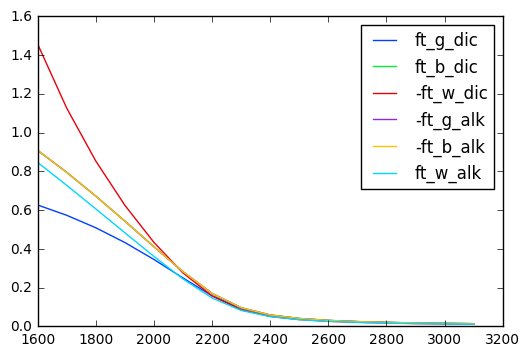

In [31]:
fig = plt.figure()
ax = plt.axes()

dic_umol = ft_dic*1000 
ax.plot(dic_umol,ft_g_dic*1000);
ax.plot(dic_umol,ft_b_dic*1000);
ax.plot(dic_umol,-ft_w_dic*1000);
ax.plot(dic_umol,-ft_g_alk*1000);
ax.plot(dic_umol,-ft_b_alk*1000);
ax.plot(dic_umol,ft_w_alk*1000);
legtext = ['ft_g_dic', 'ft_b_dic', '-ft_w_dic', '-ft_g_alk', '-ft_b_alk', 'ft_w_alk']
ax.legend(legtext)